# Let's create some simple fake data

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## For the Crosstabs Example

Let's generate some fake data:

In [2]:
def gimme_data():
    
    n = 500
    k = 100
    df = pd.DataFrame()
    ids = np.arange(n)
    np.random.shuffle(ids)
    df['entity_id'] = ids
    
    # ===== Underlying features ====== 
    
    # age is random
    df['age'] = np.random.randn(len(df)) * 15 + 45
    df.loc[df.age<0,'age'] = 1.0
    
    # gender is random
    df['gender_female'] = np.random.binomial(1, 0.6, len(df))
    
    # incident rate is random, but bi-modal
    switch = (np.random.randn(len(df)) > 0.2).astype(float)
    df['incident_rate'] = np.random.beta(5,2,len(df)) * switch + np.random.beta(1,5,len(df)) * (1-switch)
    
    # some people have a rare mutation
    df['random_feature_1'] = (np.random.randn(len(df)) > .5).astype(float)
    
    # ====== Actual risk ======
    
    # we have a latent score that determines actual risk
    df['latent_score'] = 0

    # every 30 years of age adds a risk point
    df.loc[:,'latent_score'] += df['age'] / 30

    # being male adds 1 risk points
    df.loc[df.gender_female==0, 'latent_score'] = df.loc[df.gender_female==0, 'latent_score'] + 2

    # incident rate * 2 for risk
    df['latent_score'] = df['latent_score'] + df['incident_rate'] * 2

    # if you're young, female, and have the rare mutation, you're at very high risk
    small_group = (df.age<25)&(df.gender_female==1)&(df.random_feature_1==1)
    df.loc[small_group, 'latent_score'] = df.loc[small_group, 'latent_score'] + 25

    # remember a cutoff - above this, you're positive (90th percentile)
    cutoff = np.percentile(df.latent_score, q=90)

    # make some noooooise
    df['latent_score'] = df['latent_score'] + np.random.randn(len(df)) * 1
    
    # convert latent score to true label
    df['true_label'] = df['latent_score'] > cutoff
    del df['latent_score']
    
    # ===== Distracting Features =====
    
    for idx in range(2, 15):
        df['random_feature_%d'%idx] = ((np.random.randn(len(df)) * np.random.rand()*5 + np.random.randn()*5) > 2).astype(float)
        
    # some binary ones
    for idx in range(16, 30):
        df['random_feature_%d'%idx] = np.random.randn(len(df)) * np.random.rand()*5 + np.random.randn()*5
        
    # some boring correlates of age
    for idx in range(31, 60):
        df['random_feature_%d'%idx] = df['age'] + np.random.rand()*20 + np.random.rand()*100 +\
                                                  np.random.randn(len(df))*10
    # some boring correlates of gender
    for idx in range(61, 90):
        df['random_feature_%d'%idx] = df['gender_female'] + np.random.randn(len(df)) * np.random.rand()*5
        
    df = df[['entity_id','age','gender_female','incident_rate','true_label'] + 
            [c for c in df.columns if c.startswith('random')]]
        
    return df

#### Generate train and test set

In [3]:
train = gimme_data()
test = gimme_data()

In [4]:
train.true_label.value_counts()

False    441
True      59
Name: true_label, dtype: int64

In [5]:
test.true_label.value_counts()

False    434
True      66
Name: true_label, dtype: int64

#### Let's see if the interaction term made it through:

In [6]:
small_group = (train.age<25)&(train.gender_female==1)&(train.random_feature_1==1)
train[small_group].true_label.value_counts()

True    12
Name: true_label, dtype: int64

In [7]:
small_group = (test.age<25)&(test.gender_female==1)&(test.random_feature_1==1)
test[small_group].true_label.value_counts()

True    11
Name: true_label, dtype: int64

Yup!

### Fit and Predict with an RF

In [8]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X=train.drop(['entity_id','true_label'],1),
       y=train['true_label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [9]:
preds = rf.predict_proba(test.drop(['entity_id','true_label'],1))

#### Just making sure that the RF can do something sensible: 

In [10]:
fpr, tpr, _ = roc_curve(y_true=test.true_label, y_score=preds[:,1])

In [11]:
roc_auc = auc(fpr, tpr)

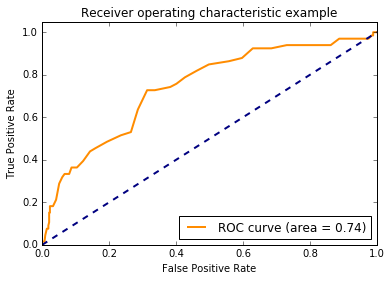

In [12]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Looking alright.

In [13]:
test['score'] = preds[:,1]

In [14]:
test = test.sort_values(by='score', ascending=False)

In [15]:
test.head(10)

,entity_id,age,gender_female,incident_rate,true_label,random_feature_1,random_feature_2,random_feature_3,random_feature_4,random_feature_5,...,random_feature_81,random_feature_82,random_feature_83,random_feature_84,random_feature_85,random_feature_86,random_feature_87,random_feature_88,random_feature_89,score
465,478,63.227958,0,0.818133,True,0.0,1.0,0.0,1.0,1.0,...,-1.766104,4.528153,-0.402657,-0.284959,2.653418,2.360303,10.957686,3.624214,0.276944,0.615
180,174,66.557592,0,0.412870,False,0.0,0.0,0.0,0.0,0.0,...,0.808632,2.705668,-0.495744,-0.390279,0.966705,-3.702808,-2.249557,0.864319,-0.984309,0.585
397,192,81.583693,0,0.354826,False,1.0,0.0,0.0,1.0,0.0,...,-3.531336,-6.141112,-1.981490,-0.471732,0.057509,1.610588,2.705318,2.498322,0.766655,0.580
215,15,57.108930,0,0.527284,False,0.0,0.0,0.0,1.0,0.0,...,-1.400378,4.954661,0.156229,-0.321477,-1.323733,0.830541,-1.726930,11.488804,1.389767,0.575
368,142,51.996117,0,0.768863,True,0.0,1.0,0.0,1.0,1.0,...,-3.840975,0.122851,-1.033036,0.071066,-4.006721,-3.869528,5.631649,3.828006,0.996846,0.565
104,126,57.526542,0,0.898845,True,0.0,0.0,0.0,1.0,0.0,...,-1.693623,1.874155,-1.421506,-0.204338,3.209767,-1.363325,-2.548176,-5.714439,-1.685581,0.565
328,375,44.509787,0,0.586849,False,0.0,0.0,0.0,1.0,1.0,...,-0.501809,3.066686,-0.485009,0.100575,3.096863,0.061533,-2.806147,-2.001836,-1.398406,0.565
99,370,67.807486,0,0.561012,False,0.0,0.0,0.0,1.0,0.0,...,1.671493,4.571253,0.137551,-0.379693,2.269276,-4.799680,5.481302,-4.811187,2.561597,0.560
225,41,65.159263,0,0.673079,False,0.0,0.0,0.0,1.0,0.0,...,-1.037459,1.810626,-0.490970,-0.545345,-1.355171,-0.018782,6.332184,-2.682034,2.491792,0.560
198,37,55.379742,0,0.923638,True,0.0,0.0,1.0,1.0,0.0,...,-0.416719,1.484297,1.548530,-0.031410,-1.359145,-0.330880,-0.239769,-6.869188,-2.498499,0.560


But didn't pick up on the interaction term.

In [16]:
# rearrange columns a bit
test = test[['entity_id','true_label','score'] + [c for c in test.columns if c not in ['entity_id','true_label','score']]]

In [31]:
test.to_csv('test_data.csv', index=False)

### For the bias exercise

In [21]:
test[['entity_id','score','true_label','gender_female','age']].to_csv('bias_exercise.csv',index=False)